In [14]:
# import libraries
import time as time
import pandas as pd
import numpy as np
np.random.seed(42)
import sys
import os
import os.path
import itertools
import matplotlib.pyplot as plt

# import custom libraries
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pkgs.loadData import *
from pkgs.logRegAlgo import *
from pkgs.results import *
print('packages loaded')

packages loaded


In [15]:
# load data
dataCV, dataTrn, dataTst = loadData('data/csv-format/CVfolds/','data/csv-format/train.csv','data/csv-format/test.csv')

Reading validation fold: 1
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 2
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 3
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 4
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Addi

In [17]:
def runLogReg_CV(dataCV, es):
    # Using current time 
    t_st = time.time()
    
    lrs = [10**0, 10**-1, 10**-2, 10**-3, 10**-4, 10**-5]; #intiial learning rates
    sig2s = [10**-1, 10**0, 10**1, 10**2, 10**3, 10**4,]; #initial tradeoffs
    
    hps = list(itertools.product(lrs, sig2s))
    best_perf = pd.DataFrame(columns=['Ep','lr', 'sig2', 'acc', 'obj']); 
    T = 10;
    
    for f in dataCV:
        print('-> Fold -', f, end=" ")
        # data prep for validation fold
        dataVal = dataCV[f]['val'].to_numpy()
        X_val = dataVal[:,1:]; X_val = np.hstack((X_val, np.ones((X_val.shape[0],1)))); # add bias
        y_val = dataVal[:,0];            
        # data fold for training
        data = dataCV[f]['trn'];      
        acc0 = 0; # reset accuracy
        
        for lr, sig2 in hps: # for learning rates and tradeoff combinations
            
            # No early stop threshold for CV: es = 'None'
            # CV training
            w_best, _, lc, obj, losses = logReg(data, lr, sig2, es, T)
            # CV validation 
            acc_Val = accuracy(X_val, y_val, w_best) # accuracy(X,y,w):
        
            if acc_Val > acc0:
                best_perf.loc[f] = [len(lc), lr, sig2, acc_Val, obj[-1]]
                acc0 = acc_Val
            
    print('\n -- Best Performance over CV Folds -- ')
    print(best_perf)        
    print('\nEarly stop:', es)      
    t_en = time.time()
    t_run = np.round((t_en - t_st)/60,3)
    print('\nRuntime (m):', t_run)
    
    return best_perf, t_run

# repeat cross validation
repeats = 3;
reps = {}; runtimes = {}; 
es = 'None'; avgObj = 0; avgAcc  = 0;
for r in range(repeats):
    # input dataCV and early stopping factor
    print('\nTRIAL', r)
    logReg_bestHP, t_run = runLogReg_CV(dataCV, es);
    avgObj += logReg_bestHP.obj.mean();
    avgAcc += logReg_bestHP.acc.mean();
    reps[r] = logReg_bestHP;
    runtimes[r] = t_run    

# average cross validation objective value for early stopping definition
avgObj = int(avgObj/repeats)
avgCVacc = avgAcc/repeats

print('\nAverage CV accuracy: {:.4f}'.format(avgCVacc))

-> Fold - 1 

C:\Users\Alex\Documents\GitHub\CS6450 - Machine Learning\hw6\palomino_HW6\pkgs\logRegAlgo.py:76: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))
C:\Users\Alex\Documents\GitHub\CS6450 - Machine Learning\hw6\palomino_HW6\pkgs\logRegAlgo.py:91: RuntimeWarning: overflow encountered in exp
  loss += np.log(1 + np.exp(-yi*wTdotxi))


-> Fold - 2 -> Fold - 3 -> Fold - 4 -> Fold - 5 
 -- Best Performance over CV Folds -- 
     Ep   lr     sig2       acc          obj
1  10.0  1.0  10000.0  0.721973   880.348438
2  10.0  1.0  10000.0  0.775785   746.696220
3  10.0  1.0  10000.0  0.748879   704.953241
4  10.0  1.0  10000.0  0.755605   671.518667
5  10.0  1.0  10000.0  0.726457  1128.980010

Early stop: None

Runtime (m): 0.117

Average CV accuracy: 0.7457



    Early stop - epoch 10
    Objective values 847.893 -> 842.725

Train accuracy: 0.8278


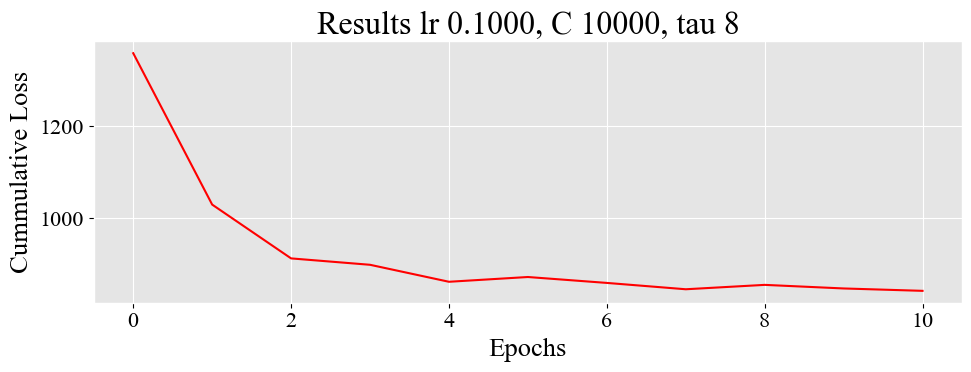

In [22]:
#%% train with best HP
def runLogReg_trn(dataTrn, lr, sig2, tau, T):
    
    w_best, best_acc, lc, obj, losses = logReg(dataTrn, lr, sig2, tau, T)
    
    print('\nTrain accuracy: {:.4f}'.format(best_acc))
    
    return w_best, best_acc, lc, obj, losses

bestLr = 0.1; bestSig2 = 10000; 
# early stop condition = 1% of avg. CV objective
bestTau = int(0.01*avgObj); T = 100;

logReg_Trn = {}
logReg_Trn['w'], logReg_Trn['Acc'], logReg_Trn['LC'], logReg_Trn['Obj'], logReg_Trn['Losses'] = runLogReg_trn(dataTrn, bestLr, bestSig2, bestTau, T)
 
plot_loss(logReg_Trn['Losses'], bestLr, bestSig2, bestTau, 'logReg_trnLoss.pdf')

In [23]:
#% test with best weight vector
def runLogReg_tst(dataTst, w):
    
    data_np = dataTst.to_numpy() # split data
    y = data_np[:,0]
    X = data_np[:,1:]
    X = np.hstack((X, np.ones((X.shape[0],1)))) # add bias
    
    acc = accuracy(X,y,w);
    
    print('\nTest accuracy: {:.3f}'.format(acc))
    
    return acc

tstAcc = runLogReg_tst(dataTst, logReg_Trn['w'])


Test accuracy: 0.780
